# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict
import matplotlib.pyplot as plt

In [27]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [28]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [29]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [30]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x7d347f996150

In [31]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.09s/it]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [32]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.56s/it]


[0 1 3 4 5 6]


In [33]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label'])

## 4. Visualize the tomogram and painted segmentation from ground-truth picks

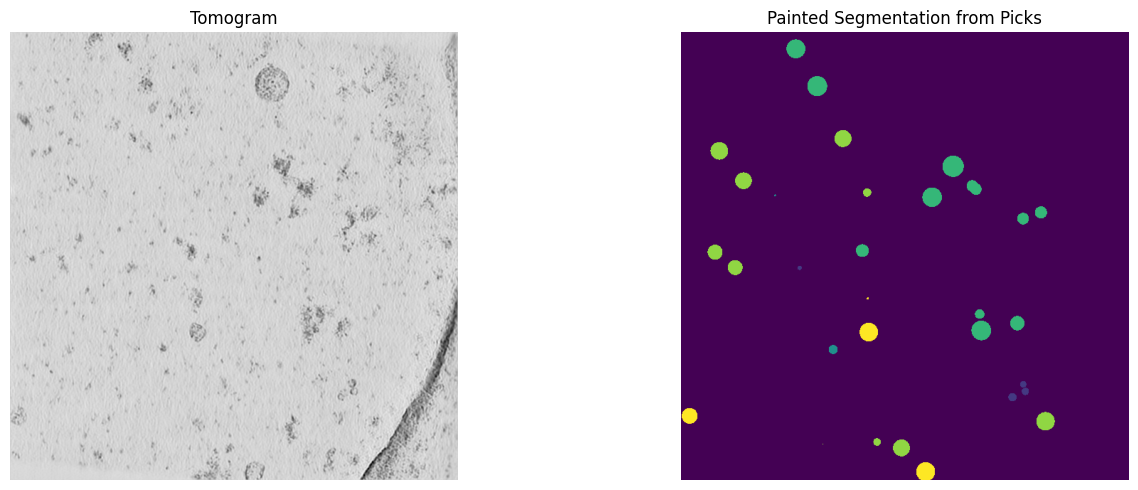

In [34]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Simulated data prep

In [2]:
simulated_data_path = '../../simulated_training_data/'

In [3]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

['TS_26',
 'TS_13',
 'TS_22',
 'TS_17',
 'TS_1',
 'TS_24',
 'TS_19',
 'TS_4',
 'TS_6',
 'TS_23',
 'TS_2',
 'TS_16',
 'TS_14',
 'TS_20',
 'TS_18',
 'TS_0',
 'TS_21',
 'TS_3',
 'TS_9',
 'TS_7',
 'TS_10',
 'TS_11',
 'TS_25',
 'TS_12',
 'TS_15',
 'TS_5',
 'TS_8']

In [86]:
temp_zarr = zarr.open(simulated_data_path + f'{'TS_0'}/Reconstructions/VoxelSpacing10.000/Tomograms/100/TS_0.zarr', mode='r')
temp_zarr

<zarr.hierarchy.Group '/' read-only>

In [87]:
temp_zarr[0].shape

(200, 630, 630)

In [88]:
image = temp_zarr[0]

In [89]:
image = image - np.min(image)

In [90]:
image = image / np.max(image)

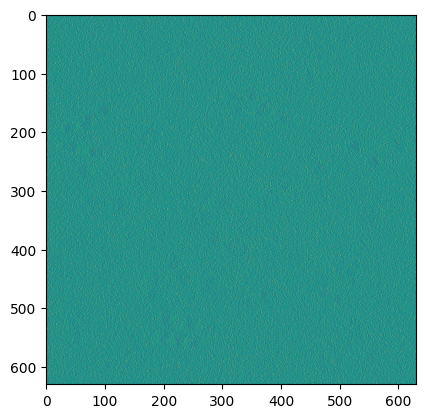

In [91]:
plt.imshow(image[100])

In [10]:
viewer = napari.Viewer()
viewer.add_image(image, colormap="gray", name="CryoET Image")

<Image layer 'CryoET Image' at 0x7d34843d9b50>

In [57]:
temp_zarr = zarr.open(simulated_data_path + f'{'TS_0'}/Reconstructions/VoxelSpacing10.000/Annotations/101/ferritin_complex-1.0_segmentationmask.zarr', mode='r')
temp_zarr

<zarr.hierarchy.Group '/' read-only>

In [58]:
len(temp_zarr)

3

In [59]:
temp_zarr[0]

<zarr.core.Array '/0' (200, 630, 630) int8 read-only>

In [60]:
image = temp_zarr[0]
image.shape

(200, 630, 630)

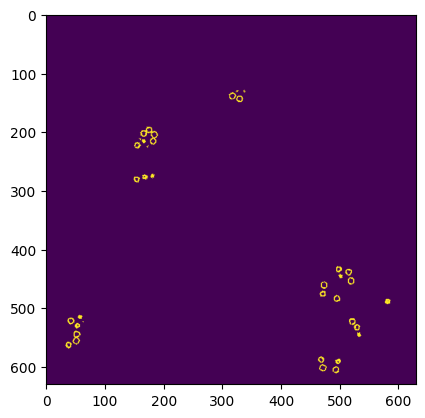

In [61]:
plt.imshow(image[100])

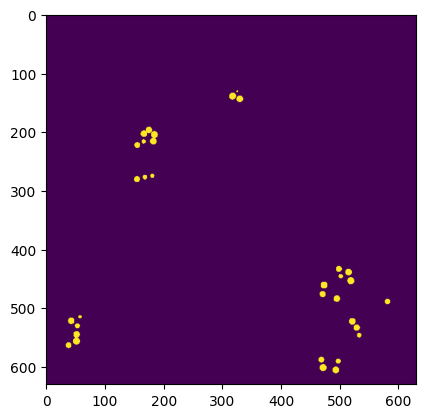

In [100]:
plt.imshow(mask_image[100])

In [26]:
viewer = napari.Viewer()
viewer.add_image(image, colormap="gray", name="CryoET Image")

<Image layer 'CryoET Image' at 0x7d347bfeed80>

In [36]:
import json

In [37]:
with open(f'{simulated_data_path}{'TS_0'}/Reconstructions/VoxelSpacing10.000/Annotations/101/ferritin_complex-1.0_orientedpoint.ndjson') as f:
    loaded_json = json.loads(f.read())

JSONDecodeError: Extra data: line 2 column 1 (char 321)

In [39]:
import pandas as pd

In [41]:
prac_df = pd.read_json(f'{simulated_data_path}{'TS_0'}/Reconstructions/VoxelSpacing10.000/Annotations/101/ferritin_complex-1.0_orientedpoint.ndjson', lines=True)
prac_df

,type,location,xyz_rotation_matrix
0,orientedPoint,"{'x': 184.7234022, 'y': 201.2950073, 'z': 88.3...","[[-0.166752607406626, -0.9859181649799751, 0.0..."
1,orientedPoint,"{'x': 174.83648290000002, 'y': 196.9210912, 'z...","[[0.46668994680803405, -0.8806027748810351, -0..."
2,orientedPoint,"{'x': 166.2992079, 'y': 203.3402666, 'z': 102....","[[0.031204748487038, 0.693169301415764, 0.7200..."
3,orientedPoint,"{'x': 159.9109843, 'y': 211.89711830000002, 'z...","[[0.531861904004153, 0.836387786343851, 0.1325..."
4,orientedPoint,"{'x': 154.8594538, 'y': 222.5874288, 'z': 103....","[[-0.9020414571977491, 0.26564194938733304, 0...."
...,...,...,...
188,orientedPoint,"{'x': 509.47505950000004, 'y': 550.77093050000...","[[-0.776311337433483, 0.523511829166012, 0.351..."
189,orientedPoint,"{'x': 508.55089580000003, 'y': 548.62718969999...","[[-0.913180963488961, 0.24895648386556402, 0.3..."
190,orientedPoint,"{'x': 501.85618089999997, 'y': 558.4130653, 'z...","[[0.11153883406178201, 0.5019284441659111, 0.8..."
191,orientedPoint,"{'x': 68.0923584, 'y': 532.0722998, 'z': 160.5...","[[-0.38775813089278804, -0.9208739778511821, -..."


In [51]:
prac_df['x'] = prac_df['location'].apply(lambda x: x['x'])
prac_df['y'] = prac_df['location'].apply(lambda x: x['y'])
prac_df['z'] = prac_df['location'].apply(lambda x: x['z'])
prac_df

,type,location,xyz_rotation_matrix,x,y,z
0,orientedPoint,"{'x': 184.7234022, 'y': 201.2950073, 'z': 88.3...","[[-0.166752607406626, -0.9859181649799751, 0.0...",184.723402,201.295007,88.392834
1,orientedPoint,"{'x': 174.83648290000002, 'y': 196.9210912, 'z...","[[0.46668994680803405, -0.8806027748810351, -0...",174.836483,196.921091,97.601095
2,orientedPoint,"{'x': 166.2992079, 'y': 203.3402666, 'z': 102....","[[0.031204748487038, 0.693169301415764, 0.7200...",166.299208,203.340267,102.135759
3,orientedPoint,"{'x': 159.9109843, 'y': 211.89711830000002, 'z...","[[0.531861904004153, 0.836387786343851, 0.1325...",159.910984,211.897118,93.933608
4,orientedPoint,"{'x': 154.8594538, 'y': 222.5874288, 'z': 103....","[[-0.9020414571977491, 0.26564194938733304, 0....",154.859454,222.587429,103.401403
...,...,...,...,...,...,...
188,orientedPoint,"{'x': 509.47505950000004, 'y': 550.77093050000...","[[-0.776311337433483, 0.523511829166012, 0.351...",509.475060,550.770931,114.593852
189,orientedPoint,"{'x': 508.55089580000003, 'y': 548.62718969999...","[[-0.913180963488961, 0.24895648386556402, 0.3...",508.550896,548.627190,129.774321
190,orientedPoint,"{'x': 501.85618089999997, 'y': 558.4130653, 'z...","[[0.11153883406178201, 0.5019284441659111, 0.8...",501.856181,558.413065,133.613202
191,orientedPoint,"{'x': 68.0923584, 'y': 532.0722998, 'z': 160.5...","[[-0.38775813089278804, -0.9208739778511821, -...",68.092358,532.072300,160.530637


In [52]:
prac_df['x'].max()

603.4114185000001

In [62]:
image.shape

(200, 630, 630)

In [76]:
background_image = np.zeros(image.shape)
background_image.shape

(200, 630, 630)

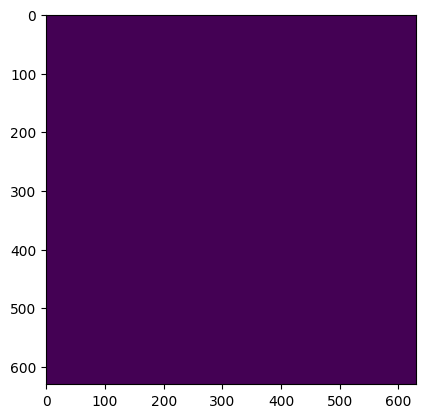

In [77]:
plt.imshow(background_image[100])

In [98]:
def create_masks(image, locations_df):
    shape = image.shape
    volume = np.zeros(shape)

    for i in tqdm(range(locations_df.shape[0])):
        center = (locations_df.loc[i, 'z'], locations_df.loc[i, 'y'], locations_df.loc[i, 'x'])
        radius = 60/10
        intensity = 1

        z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
        
        mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= radius**2

        volume[mask] = intensity

    return volume

In [99]:
mask_image = create_masks(image, prac_df)
mask_image.shape

100%|█████████████████████████████████████████| 193/193 [00:22<00:00,  8.73it/s]


(200, 630, 630)

In [81]:
shape = (200, 630, 630)

# Define sphere parameters
center = (100.5, 315, 315)  # (z, y, x) center of the sphere
radius = 50  # Radius of the sphere
intensity = 255  # Intensity value inside the sphere

# Create a 3D grid
z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]

# Equation of a sphere: (x-x0)^2 + (y-y0)^2 + (z-z0)^2 <= r^2
mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= radius**2

# Apply the mask to insert the sphere
background_image[mask] = intensity

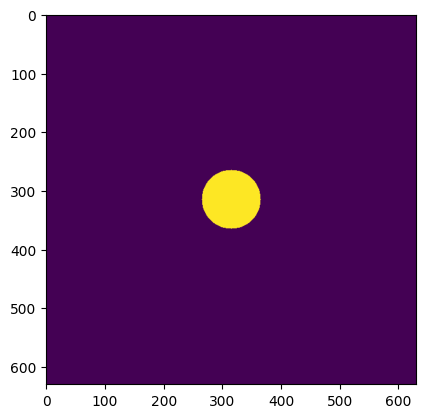

In [82]:
plt.imshow(background_image[100])

## 5. Prepare dataloaders

In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric

In [ ]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[:5], data_dicts[5:7]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

## Model setup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [ ]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=25):
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\ncurrent mean recall: {metric:.4f} "
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [ ]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 10000
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

**Note:** Code taken from the official CZ Imaging Institute's official github page.